# Guia 1

Grupo 5
- Favio Di Ciocco
- Mauro Silberberg

## Librerías y funciones

In [ ]:
import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
import numba

### Derivadas por diferencias finitas

Usamos `np.roll` para desplazar el array y calcular la diferencia entre vecinos.

In [ ]:
@numba.njit
def first_derivative(y, dx):
    return (np.roll(y, -1) - np.roll(y, 1)) / (2 * dx)

@numba.njit
def second_derivative(y, dx):
    return (np.roll(y, -1) - 2 * y + np.roll(y, 1)) / dx**2

### Derivadas en el espacio de frecuencias

Como vamos a usar `np.fft.rfft`,
que da solo los coeficientes positivos,
generamos el vector de frecuencias como $(0, 1, \ldots, N)$.

Para matar las frecuencias altas,
solo hace falta eliminar los últimos coeficientes del array de frecuencias.

In [ ]:
@numba.njit
def fourier_derivative(frequencies, order: int):
    k = np.arange(frequencies.size)
    return (1j * k)**order * frequencies

@numba.njit
def threshold_coefficients(frequencies, threshold):
    N = frequencies.size * (1 - threshold)
    N = int(N)
    frequencies[N:] = 0
    return frequencies

### La ecuación de Burgers

La versión por diferencias finitas
toma un array de parámetros $p = (\mu, \Delta x)$,
donde $\Delta x$ es la separación entre puntos de la grilla.

In [ ]:
@numba.njit
def burgers(t, y, p):
    nu, dx = p
    return -y * first_derivative(y, dx) + nu * second_derivative(y, dx)

La versión pseudoespectral toma un array de parámetros $p = (\mu, k_{frac})$,
donde $k_{frac}$ es la fración de frecuencias a eliminar.
La recomendación es $k_{frac} = 1/3$.

In [ ]:
@numba.njit
def burgers_pseudospectral(t, y, p):
    nu, threshold = p
    dy = fourier_derivative(y, 1)
    with numba.objmode(y_dy="complex128[:]"):
        y_dy = np.fft.rfft(np.fft.irfft(y) * np.fft.irfft(dy))
    y_dy = threshold_coefficients(y_dy, threshold)
    return -y_dy + nu * fourier_derivative(y, 2)

### Integrador

Para dar un paso de integración,
usamos el método del punto medio,
o *midpoint*.

In [ ]:
@numba.njit
def midpoint(rhs, t, y, p, dt):
    t_mid = t + dt / 2
    y_mid = y + dt / 2 * rhs(t, y, p)
    t = t + dt
    y = y + dt * rhs(t_mid, y_mid, p)
    return t, y

Para realizar la integración,
definimos dos funciones,
`n_steps` y `upto_t`.

La primera,
`n_steps`,
guarda todos los pasos de integración.
La segunda,
`upto_t`,
solo guarda `n_points` equiespaciados de la solución.

In [ ]:
@numba.njit
def n_steps(rhs, t0, y0, p, *, dt: float, n_steps: int):
    n_steps = n_steps + 1
    t = np.empty(n_steps)
    y = np.empty((n_steps, y0.size), dtype=y0.dtype)
    t[0] = t0
    y[0] = y0
    for step in range(1, n_steps):
        t0, y0 = midpoint(rhs, t0, y0, p, dt)
        t[step] = t0
        y[step] = y0
    return t, y

@numba.njit
def upto_t(rhs, t0, y0, p, *, dt: float, n_points: int, t_end: float):
    t = np.empty(n_points)
    y = np.empty((n_points, y0.size), dtype=y0.dtype)

    n_steps = int((t_end - t0) / dt)
    save_every = n_steps // n_points
    if save_every == 0:
        raise ValueError("dt es más grande que (t_end - t0) / n_points.")
    
    for i in range(n_points):
        t[i] = t0
        y[i] = y0
        for _ in range(save_every):
            t0, y0 = midpoint(rhs, t0, y0, p, dt)
    return t, y

### Energía total

Para calcular la energía $E$,
sumamos la velocidad $u^2 / 2$:
$$E = \sum_i \frac{u_i^2}{2}$$

In [ ]:
def energia(u, axis=-1):
    return (u**2 / 2).sum(axis=axis)

### Condición inicial

Como condición inicial,
generamos perfil de velocidades sinusoidal.

In [ ]:
def grilla(n_points: int):
    x, dx = np.linspace(0, 2 * np.pi, num=n_points, endpoint=False, retstep=True)
    return x, dx

def condicion_inicial(x):
    t0 = 0
    y0 = np.sin(x)
    return t0, y0

### Simulación

Generamos una función para simular
por diferencias finitas y pseudoespectral
con los mismos parámetros.

In [ ]:
def simular(
    *,
    nu: float,
    tamaño_grilla: int,
    dt: float,
    t_end: float,
    n_points: int,
    threshold: float = 1 / 3
):
    x, dx = grilla(tamaño_grilla)
    t0, y0 = condicion_inicial(x)

    kwargs = dict(dt=dt, t_end=t_end, n_points=n_points)

    t, y_diff = upto_t(burgers, t0, y0, p=np.array([nu, dx]), **kwargs)
    _, y_spec = upto_t(
        burgers_pseudospectral, t0, np.fft.rfft(y0), p=np.array([nu, threshold]), **kwargs
    )
    y_spec = np.fft.irfft(y_spec)

    return {
        "t": t,
        "x": x,
        "dx": dx,
        "y_diff": y_diff,
        "y_pseudoespectral": y_spec,
    }


def set_prop_cycle(ax, N: int, *, cmap="viridis"):
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    colors = [cmap(k) for k in np.linspace(0, 1, N)]
    ax.set_prop_cycle(color=colors)

## 1) La ecuación de Burgers

> a) Derive la forma conservativa de la ecuación de Burgers.
\begin{align}
\frac{\partial u}{\partial t} = - \frac{\partial }{\partial x} \left( \frac{u^2}{2} \right) + \nu \frac{\partial^2 u}{\partial x^2}
\end{align}
> En el caso que $\nu = 0$,
¿Qué magnitud se conserva cuando la ecuación se integra en un recinto [a,b]?
(Ayuda:
recuerde que existe la densidad $\rho$)
>
> b) Derive una ecuación diferencial y una ecuación integral para el balance de la densidad de energía cinética $E \equiv \frac{u^2}{2}$.
Interprete cada uno de los términos.
>
> c) Muestre que $\omega \equiv \frac{\partial u}{\partial x}$ satisface la siguiente ecuación,
\begin{align}
\frac{D \omega}{D t} = - \omega^2 + \nu \frac{\partial^2 \omega}{\partial x^2}
\end{align}
>
> donde $D_t \equiv \partial_t + u\partial_x$.
En caso de que $\nu = 0$,
¿Qué implica esta última ecuación para la evolución temporal de los gradientes de u?
Interprete qué sucede en aquellos puntos que cumplen $\partial_x u > 0$.

### Forma conservativa de la ecuación de Burgers

La ecuación de Burgers y su forma conservativa se diferencian únicamente en el término de la primer derivada de $u$.
Lo que debemos hacer por tanto es introducir la $u$ que está multiplicando dentro de la derivada.
Para esto lo que haremos será desarrollar la expresión $\frac{\partial }{\partial x} \left( \frac{u^2}{2} \right)$.

\begin{align}
\frac{\partial }{\partial x} \left( \frac{u^2}{2} \right) & = \frac{1}{2} \frac{\partial}{\partial x} (u \cdot u) \\
& =  \frac{1}{2} \left( \frac{\partial u}{\partial x} \cdot u + u \cdot \frac{\partial u}{\partial x} \right) \\
& = \frac{1}{2} \cdot 2 \cdot \frac{\partial u}{\partial x} \cdot u =  \boxed{u \cdot \frac{\partial u}{\partial x}}
\end{align}

Podemos entonces reemplazar el segundo término de la ecuación de Burgers para reformularla en su forma conservativa.

\begin{align}
\frac{\partial u}{\partial t} & = - u \frac{\partial u}{\partial x} + \nu \frac{\partial^2 u}{\partial x^2} \\
\frac{\partial u}{\partial t} & = - \frac{\partial}{\partial x} \left( \frac{u^2}{2} \right) + \nu \frac{\partial^2 u}{\partial x^2}
\end{align}

Si tomamos $\nu = 0$ e integramos la ecuación obtenemos la siguiente expresión.

\begin{align}
\int_a^b \frac{\partial u}{\partial t} dx =
- \int_a^b \frac{\partial}{\partial x} \left( \frac{u^2}{2} \right) dx
\end{align}

Utilizando la definición del punto *b* para la densidad de energía cinética,
el término de la derecha corresponde entonces con menos la variación de la energía cinética.

\begin{align}
- \int_a^b \frac{\partial}{\partial x} \left( \frac{u^2}{2} \right) dx =
- \left. \left( \frac{u^2}{2} \right) \right|_a^b =
- \Delta E
\end{align}

Por otro lado,
en el término de la izquierda podemos introducir la integral dentro de la derivada y considerar que el valor de $u$ se halla multiplicado por la densidad $\rho$.
De esta manera la integral resultaría en un impulso total del fluído en la región $[a,b]$.

\begin{align}
\int_a^b \frac{\partial u}{\partial t} dx = \frac{\partial}{\partial t} \int_a^b u dx =
\frac{\partial}{\partial t} \int_a^b \rho u dx =
\frac{\partial}{\partial t} P_{tot}
\end{align}

De esta manera se deduce de la ecuación de Burgers que un fluído sin viscosidad,
es decir $\nu = 0$,
presenta una variación en la energía entre dos puntos de su recorrido si ocurre una variación del momento total del fluído contenido entre esos dos puntos.

\begin{align}
\frac{\partial}{\partial t} P_{tot} =
- \Delta E
\end{align}

### Ecuación diferencial de la densidad de energía cinética

Para construir esta ecuación diferencial necesitamos que las funciones de $u$ tomen la forma de $\frac{u^2}{2}$ para poder reemplazarlas por la densidad de energía.

Como primer paso entonces,
multiplicamos la forma conservativa de la ecuación de Burgers por la velocidad $u$.
A continuación desarrollamos el término de la derivada temporal y el de la derivada segunda en $x$.

Igual que como hicimos con la derivada espacial,
podemos meter la $u$ dentro de la derivada temporal de la siguiente forma

\begin{align}
u \frac{\partial u}{\partial t} =
\frac{\partial}{\partial t} \left( \frac{u^2}{2} \right)
\end{align}

Con el término viscoso podemos partir de la derivada segunda de la densidad de energía y desarrollar la expresión.

\begin{align}
\frac{\partial^2}{\partial x^2} \left( \frac{u^2}{2} \right) & =
\frac{\partial}{\partial x} \left( \frac{\partial}{\partial x} \left( \frac{u^2}{2} \right)  \right) \\
& = \frac{\partial}{\partial x} \left( u \cdot \frac{\partial u}{\partial x} \right) \\
& = \frac{\partial u}{\partial x} \frac{\partial u}{\partial x} + u \cdot \frac{\partial^2 u}{\partial x^2}
\end{align}

Usando estos dos resultados, podemos reemplazar en la ecuación de Burgers en su forma conservativa.

\begin{align}
\frac{\partial u}{\partial t} & = - \frac{\partial}{\partial x} \left( \frac{u^2}{2} \right) + \nu \frac{\partial^2 u}{\partial x^2}
\\
\text{multiplicamos por u}
\\
u \frac{\partial u}{\partial t} & = - u \frac{\partial}{\partial x} \left( \frac{u^2}{2} \right) + \nu u \frac{\partial^2 u}{\partial x^2}
\\
\frac{\partial}{\partial t} \left( \frac{u^2}{2} \right) & = - u \frac{\partial}{\partial x} \left( \frac{u^2}{2} \right) + \nu \left[ \frac{\partial^2 }{\partial x^2} \left( \frac{u^2}{2} \right) - \left( \frac{\partial u}{\partial x} \right)^2 \right]
\\
\text{reemplazamos $\frac{u^2}{2}$ por $E$}
\\
\frac{\partial E}{\partial t} + u \frac{\partial E}{\partial x} & =  \nu \left[ \frac{\partial^2 E}{\partial x^2} - \left( \frac{\partial u}{\partial x} \right)^2 \right] \quad ; \text{$E = \frac{u^2}{2} \rightarrow \frac{\partial E}{\partial x} = u \frac{\partial u}{\partial x}$}
\\
\frac{DE}{Dt} & =  \nu \left[ \frac{\partial^2 E}{\partial x^2} - \frac{1}{2E} \left( \frac{\partial E}{\partial x} \right)^2 \right]
\end{align}

El término de la izquierda representa la derivada material de la energía cinética de una parcela,
la cual está igualada a un término viscoso que depende de dos contribuciones.
La primer contribución está dada por un término de difusión de la densidad de energía en el material,
mientras que la segunda contribución surge del cuadrado de la divergencia de $E$ dividido por $2E$.


### Ecuación integral de la densidad de energía cinética

Para obtener una ecuación integral de la densidad de energía cinética podemos partir de la ecuación diferencial e integrar todo en un recinto [a,b].
La idea sería poder aprovechar e integrar directamente los términos que contengan únicamente derivadas espaciales de la densidad de energía cinética.
Para esto, tomaremos el término de la derivada convectiva e introduciremos la velocidad u dentro de la derivada.

\begin{align}
\frac{\partial}{\partial x} \left( \frac{u^3}{2} \right) =
\frac{\partial}{\partial x} \left( u \cdot \frac{u^2}{2} \right) =
\frac{\partial u}{\partial x} \frac{u^2}{2} + u^2 \frac{\partial u}{\partial x}
\end{align}

Luego reemplazo esto en la ecuación diferencial e integro en el recinto [a,b].

\begin{align}
\frac{DE}{Dt} & = 
\nu \left[ \frac{\partial^2 E}{\partial x^2} -
\frac{1}{2E} \left( \frac{\partial E}{\partial x} \right)^2 \right] \\
\int_a^b \frac{\partial E}{\partial t} dx +
\int_a^b \left[ \frac{\partial (uE)}{\partial x} -
\frac{\partial u}{\partial x}E \right] dx & = 
\int_a^b \nu \frac{\partial^2 E}{\partial x^2} dx -
\int_a^b \frac{\nu}{2} \frac{1}{E} \left( \frac{\partial E}{\partial x} \right)^2 dx \\
\frac{\partial}{\partial t} \left[ \int_a^b E dx \right] +
\left. uE \right|_a^b -
\int_a^b \frac{\partial u}{\partial x} E dx & =
\left. \nu \frac{\partial E}{\partial x} \right|_a^b -
\frac{\nu}{2} \int_a^b \frac{1}{E}\left( \frac{\partial E}{\partial x} \right)^2 dx \\
\Delta uE -
\nu \Delta\frac{\partial E}{\partial x} & = 
- \frac{\partial}{\partial t} \left[ \int_a^b E dx \right] +
\int_a^b \frac{\partial u}{\partial x} E dx -
\frac{\nu}{2} \int_a^b \frac{1}{E}\left( \frac{\partial E}{\partial x} \right)^2 dx
\end{align}

En el último paso colocamos las magnitudes integradas a la izquierda del igual y las que tienen integrales a calcular del lado derecho.
El primer término de la izquierda representa una variación del "caudal de energía" en el recinto,
mientras que el segundo es una diferencia de los gradientes de la densidad energía.
Del lado derecho en cambio el primer término es la variación temporal de la energía total del fluído en el recinto,
mientras que el segundo y el tercero son términos más complejos en la energía.

### Ecuación diferencial de la vorticidad

Para probar la ecuación que nos piden en el enunciado podemos comenzar aplicando la derivada en x a la ecuación de Burgers.

\begin{align}
\frac{\partial u}{\partial t} & =
- u \frac{\partial u}{\partial x} +
\nu \frac{\partial^2 u}{\partial x^2} \\
\frac{\partial}{\partial t} \left( \frac{\partial u}{\partial x} \right) & =
- \frac{\partial}{\partial x} \left( u \frac{\partial u}{\partial x}  \right) +
\nu \frac{\partial^3 u}{\partial x^3} \\
\frac{\partial \omega}{\partial t} & =
-\omega^2 - u \frac{\partial \omega}{\partial x} + 
\nu \frac{\partial^3 u}{\partial x^3} \\
\frac{D \omega}{D t} & =
-\omega^2 +
\nu \frac{\partial \omega}{\partial x^2}
\end{align}

En caso de que $\nu = 0$ la expresión se reduce a lo siguiente.

\begin{align}
\frac{D \omega}{D t} = -\omega^2
\end{align}

De esta manera la derivada material de la vorticidad es siempre negativa.
En el caso de que $\partial_x u > 0$,
lo que esto implica es que la vorticidad disminuye en el tiempo.
En cambio, si $\partial_x u < 0$,
puedo considerar que $\omega = - |\omega|$.
Luego,
la ecuación se reescribe a continuación.

\begin{align}
\frac{D |\omega|}{D t} = \omega^2
\end{align}

En este caso entonces derivada material del módulo de la vorticidad es positiva.
Entonces podemos deducir que para valores positivos de $\partial_x u$,
la vorticidad disminuye a medida que el sistema evoluciona.
En cambio,
para valores negativos la intensidad de la vorticidad aumenta a medida que el sistema evoluciona.

## 2) Diferencias finitas

> a) Obtenga gráficamente la solución para distintos tiempos.
Muestre que la evolución temporal del campo de velocidades $u$ genera frentes.
>
> b) Genere un mapa de color mostrando la amplitud del campo de velocidades
a medida que aumenta el tiempo y aumenta el espacio.
>
> c) Utilice $ν$ igual a $10^{-1}$, $10^{-2}$, y $10^{-3}$,
y distintos números de puntos de grilla $N$
hasta resolver correctamente las derivadas espaciales.
Notar que al aumentar $N$,
necesariamente debe cumplir la condición CFL,
$Δt \leq Δx / U$
donde $U$ es la velocidad máxima alcanzada por el fluido.
Interprete.

### Condición CFL

Para una grilla de $N=128$ puntos,
y la condición inicial que utilizamos,
donde la velocidad máxima $U_max$ es 1,
la condición CFL nos impone que $\Delta t$ sea menor a:

In [ ]:
dx = 2 * np.pi / 128
U_max = 1

dx / U_max

0.04908738521234052

Para $\Delta t$ mayores,
la solución *explota*:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in multiply


[(-1.5, 1.5), Text(0, 0.5, 'Velocidad U')]

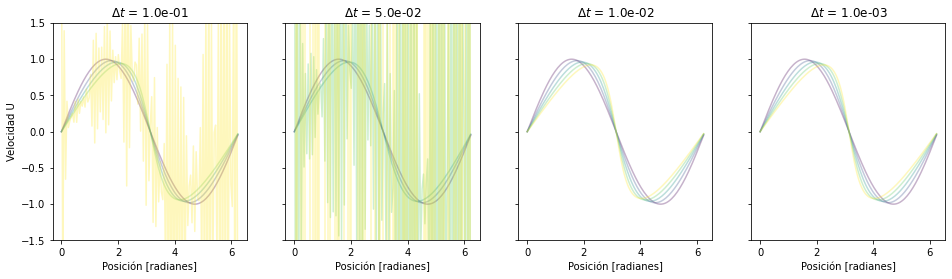

In [ ]:
dt = [0.1, 0.05, 0.01, 1e-3]
solutions = {n: simular(tamaño_grilla=128, nu=1e-1, dt=n, t_end=1, n_points=5) for n in dt}

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16, 4))
for ax, (n, sol) in zip(axes, solutions.items()):
    set_prop_cycle(ax, 5)
    ax.plot(sol["x"], sol["y_diff"].T, alpha=0.3)
    ax.set(title=f"$\Delta t$ = {n:.1e}", xlabel="Posición [radianes]")

axes[0].set(ylabel="Velocidad U", ylim=(-1.5, 1.5))

### Tamaño de grilla

Al ir disminuyendo el $\Delta x$ de la grilla,
podemos evolucionar la solución hasta mayores tiempos.

Como la solución genera frentes,
la derivada en el medio se vuelve más pronunciada,
y hace falta mayor cantidad de puntos para resolverla correctamente.

[(-1.5, 1.5), Text(0, 0.5, 'Velocidad U')]

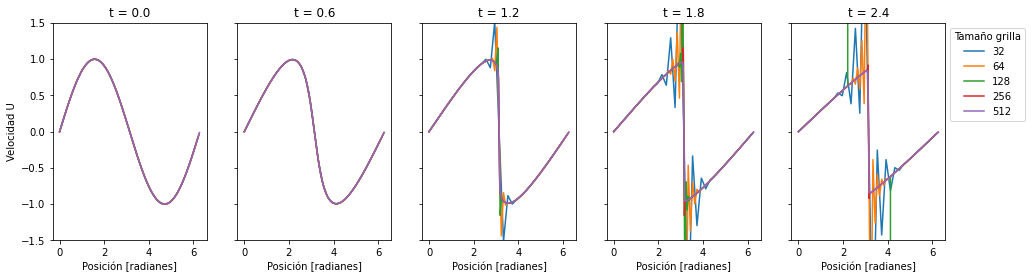

In [ ]:
N = 2**np.arange(5, 10)
solutions = {n: simular(tamaño_grilla=n, nu=1e-2, dt=1e-3, t_end=3, n_points=5) for n in N}

fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(16, 4))
for n, sol in solutions.items():
    for ax, ti, yi in zip(axes, sol["t"], sol["y_diff"]):
        ax.plot(sol["x"], yi, label=n)
        ax.set(title=f"t = {ti:.1f}", xlabel="Posición [radianes]")

axes[-1].legend(title="Tamaño grilla", bbox_to_anchor=(1, 1))
axes[0].set(ylabel="Velocidad U", ylim=(-1.5, 1.5))

### Comparación $\nu$

Al disminuir $\nu$,
estamos apagando el término disipativo,
y los frentes colisionan a mayor velocidad,
generando gradientes más pronunciados.
La solución numérica *estalla* a tiempos más cortos
para $\nu$ más pequeños.

[(-1.5, 1.5), Text(0, 0.5, 'Velocidad U')]

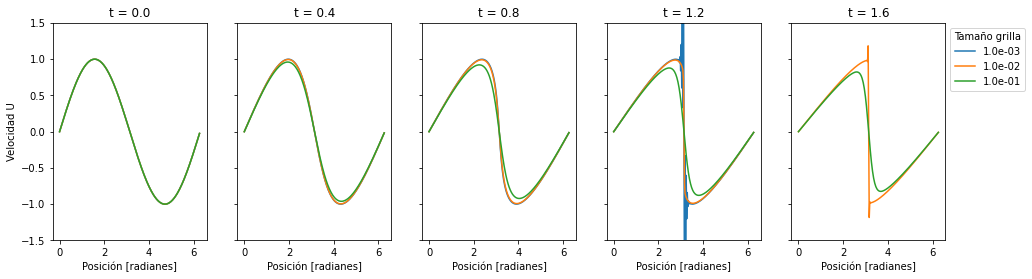

In [ ]:
nu = np.logspace(-3, -1, 3)
solutions = {n: simular(tamaño_grilla=256, nu=n, dt=1e-3, t_end=2, n_points=5) for n in nu}

fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(16, 4))
for n, sol in solutions.items():
    for ax, ti, yi in zip(axes, sol["t"], sol["y_diff"]):
        ax.plot(sol["x"], yi, label=f"{n:.1e}")
        ax.set(title=f"t = {ti:.1f}", xlabel="Posición [radianes]")

axes[-1].legend(title="Tamaño grilla", bbox_to_anchor=(1, 1))
axes[0].set(ylabel="Velocidad U", ylim=(-1.5, 1.5))

[Text(0, 0.5, 'Tiempo')]

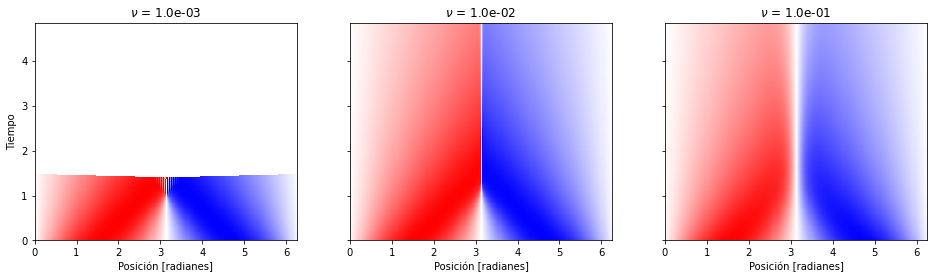

In [ ]:
nu = np.logspace(-3, -1, 3)
solutions = {n: simular(tamaño_grilla=256, nu=n, dt=1e-3, t_end=5, n_points=256) for n in nu}

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16, 4))
for ax, (nu, sol) in zip(axes, solutions.items()):
    ax.set(title=f"$\\nu$ = {nu:.1e}", xlabel="Posición [radianes]")
    ax.pcolormesh(sol["x"], sol["t"], sol["y_diff"], vmin=-1, vmax=1, cmap="bwr")
axes[0].set(ylabel="Tiempo")


## 3) Método pseudoespectral

> Resuelva nuevamente los items a), b) y c) del Problema 2
haciendo uso del método pseudo-espectral.
¿Qué diferencias observa?

Para situaciones donde las derivadas se resuelven correctamente,
no notamos diferencias entre las soluciones.

[Text(0, 0.5, 'Velocidad U')]

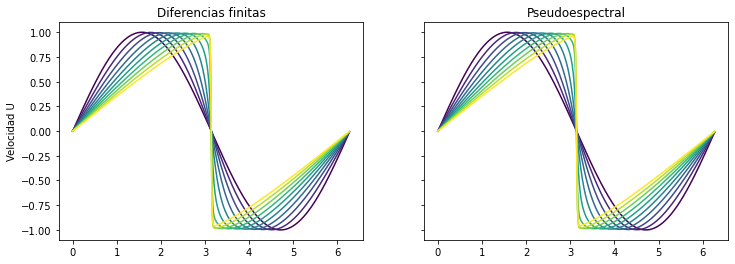

In [ ]:
sol = simular(tamaño_grilla=512, nu=1e-2, dt=1e-3, t_end=2, n_points=10)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))
for ax in axes:
    set_prop_cycle(ax, 10)
axes[0].plot(sol["x"], sol["y_diff"].T)
axes[1].plot(sol["x"], sol["y_pseudoespectral"].T)
axes[0].set(title="Diferencias finitas")
axes[1].set(title="Pseudoespectral")
axes[0].set(ylabel="Velocidad U")

Sin embargo,
cuando la derivada no se puede resolver,
se observa un comportamiento distinto en como *estalla* la solución.

La solución de diferencias finitas
propaga soluciones erroneas desde el punto donde el gradiente no se puede resolver.
En cambio,
el método pseudoespectral distribuye globalmente el error.

[(-1.5, 1.5), Text(0, 0.5, 'Velocidad U')]

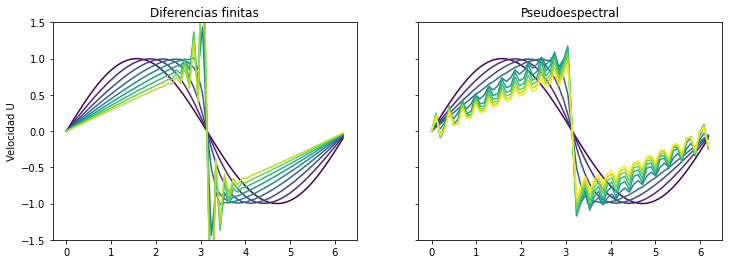

In [ ]:
sol = simular(tamaño_grilla=64, nu=1e-2, dt=1e-3, t_end=3, n_points=10)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))
for ax in axes:
    set_prop_cycle(ax, 10)
axes[0].plot(sol["x"], sol["y_diff"].T)
axes[1].plot(sol["x"], sol["y_pseudoespectral"].T)
axes[0].set(title="Diferencias finitas")
axes[1].set(title="Pseudoespectral")
axes[0].set(ylabel="Velocidad U", ylim=(-1.5, 1.5))

A diferencia del método de diferencias finitas,
el método pseudoespectral
nos permite resolver la ecuación para $\nu$ pequeño hasta tiempos más largos.
Pero aparecen oscilaciones "espurias" en las frecuencias más altas.

[Text(0, 0.5, 'Tiempo')]

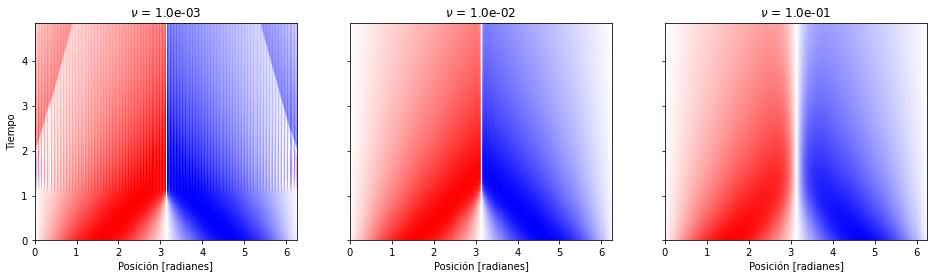

In [ ]:
nu = np.logspace(-3, -1, 3)
solutions = {n: simular(tamaño_grilla=256, nu=n, dt=1e-3, t_end=5, n_points=256) for n in nu}

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16, 4))
for ax, (nu, sol) in zip(axes, solutions.items()):
    ax.set(title=f"$\\nu$ = {nu:.1e}", xlabel="Posición [radianes]")
    ax.pcolormesh(sol["x"], sol["t"], sol["y_pseudoespectral"], vmin=-1, vmax=1, cmap="bwr")
axes[0].set(ylabel="Tiempo")

[(-1.5, 1.5), Text(0, 0.5, 'Velocidad U')]

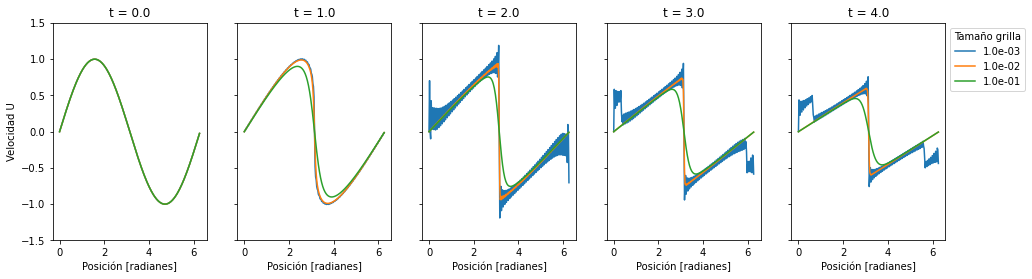

In [ ]:
nu = np.logspace(-3, -1, 3)
solutions = {n: simular(tamaño_grilla=256, nu=n, dt=1e-3, t_end=5, n_points=5) for n in nu}

fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(16, 4))
for n, sol in solutions.items():
    for ax, ti, yi in zip(axes, sol["t"], sol["y_pseudoespectral"]):
        ax.plot(sol["x"], yi, label=f"{n:.1e}")
        ax.set(title=f"t = {ti:.1f}", xlabel="Posición [radianes]")

axes[-1].legend(title="Tamaño grilla", bbox_to_anchor=(1, 1))
axes[0].set(ylabel="Velocidad U", ylim=(-1.5, 1.5))

## 4) Conservación de la energía

> Resuelva la ecuación (1) con $ν = 0$ usando ambos métodos.
a) Estudie la conservación de la energía en cada método.
¿Qué ocurre con la solución numérica para tiempos largos en cada caso?
Compare,
para iguales valores de $N$ y $ν$,
las soluciones de ambos métodos numéricos.
¿Cómo evoluciona $E$?

A diferencia del método de diferencias fínitas,
que "crea" energía cuando no puede resolver las derivadas,
el método pseudoespectral conserva la energía a tiempos largos.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


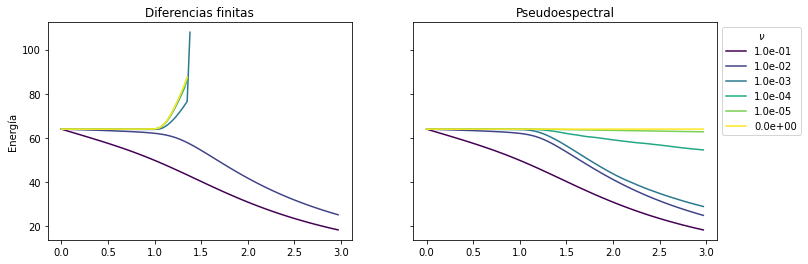

In [ ]:
nu = np.logspace(-5, -1, 5)[::-1]
nu = np.append(nu, 0)

solutions = {n: simular(tamaño_grilla=256, nu=n, dt=1e-3, t_end=3, n_points=100) for n in nu}

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
for ax in axes:
    set_prop_cycle(ax, len(solutions))
for nu, sol in solutions.items():
    axes[0].plot(sol["t"], energia(sol["y_diff"]), label=f"{nu:.1e}")
    axes[1].plot(sol["t"], energia(sol["y_pseudoespectral"]), label=f"{nu:.1e}")

axes[0].set(title="Diferencias finitas")
axes[1].set(title="Pseudoespectral")
axes[0].set(ylabel="Energía")
axes[1].legend(title="$\\nu$", bbox_to_anchor=(1, 1), loc="upper left")

> b) Según la ecuación (6),
el término de advección en la ecuación de Burgers
debería amplificar los gradientes negativos.
Verifique numéricamente que esto ocurra en las soluciones halladas.
Calcule, por ejemplo, los histogramas de $ω$ en función del tiempo.

In [ ]:
sol = simular(tamaño_grilla=256, nu=0, dt=1e-3, t_end=1, n_points=10)

Tanto en diferencias fínitas como en pseudoesepectral,
los gradientes tienden a concentrarse alrededor de $U \sim 0.5$,
a excepción de los correspondientes al choque de frentes,
que tienden a valores cada vez más negativos.
En el gráfico de la derecha,
mostramos el mínimo de los gradientes.

**Diferencias fínitas:**

[Text(0, 0.5, '$\\omega$ mínimo'), Text(0.5, 0, 'Tiempo')]

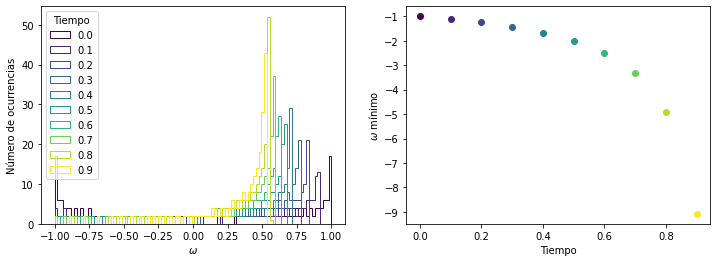

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax in axes:
    set_prop_cycle(ax, 10)

bins = np.linspace(-1, 1, 100)
for ti, yi in zip(sol["t"], sol["y_diff"]):
    w = first_derivative(yi, sol["dx"])
    axes[0].hist(w, bins=bins, histtype="step", label=f"{ti:.1f}")
    axes[1].scatter(ti, np.min(w))

axes[0].legend(title="Tiempo", loc="upper left")
axes[0].set(xlabel="$\omega$", ylabel="Número de ocurrencias")
axes[1].set(xlabel="Tiempo", ylabel="$\omega$ mínimo")

**Pseudoespectral**

[Text(0, 0.5, '$\\omega$ mínimo'), Text(0.5, 0, 'Tiempo')]

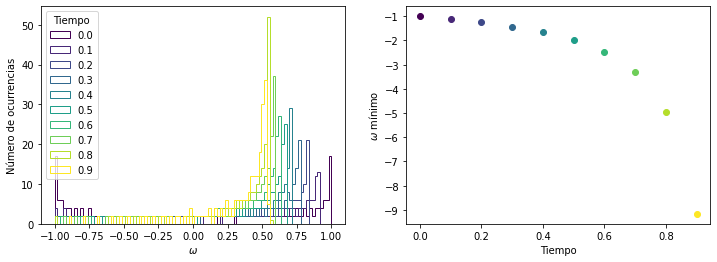

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax in axes:
    set_prop_cycle(ax, 10)

bins = np.linspace(-1, 1, 100)
for ti, yi in zip(sol["t"], sol["y_pseudoespectral"]):
    w = first_derivative(yi, sol["dx"])
    axes[0].hist(w, bins=bins, histtype="step", label=f"{ti:.1f}")
    axes[1].scatter(ti, np.min(w))

axes[0].legend(title="Tiempo", loc="upper left")
axes[0].set(xlabel="$\omega$", ylabel="Número de ocurrencias")
axes[1].set(xlabel="Tiempo", ylabel="$\omega$ mínimo")

## 5) Espectro de energía cinética

> ¿Hasta qué número de onda $k_{max}$ está definido este espectro?

La frecuencia máxima depende del tamaño de grilla usado.
Si el espaciado es $\Delta x$,
la frecuencia máxima es $\frac{1}{2\Delta x}$.

En el caso pseudoespectral,
al usar el criterio de los 2/3,
la frecuencia máxima es 2/3 menor.

In [ ]:
sol = simular(tamaño_grilla=256, nu=0, dt=1e-3, t_end=1, n_points=10)

[Text(0.5, 1.0, 'Pseudoespectral')]

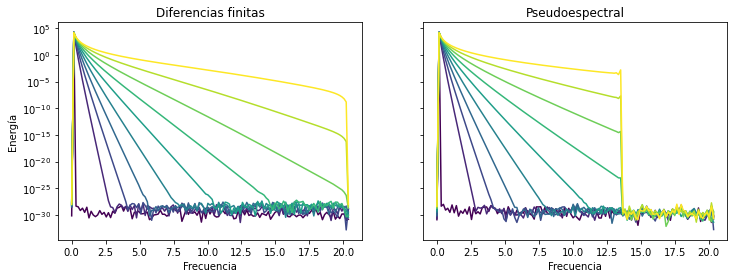

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))
for ax in axes:
    set_prop_cycle(ax, 10)

for ax, y in zip(axes, (sol["y_diff"], sol["y_pseudoespectral"])):
    ax.semilogy(
        np.fft.rfftfreq(len(sol["x"]), sol["dx"]),
        np.abs(np.fft.rfft(y)).T**2
    )
    ax.set(xlabel="Frecuencia")

axes[0].set(title="Diferencias finitas", ylabel="Energía")
axes[1].set(title="Pseudoespectral")

Cuando el término no lineal
introduce frecuencias mayores a la máxima,
los espectros de diferencias finitas y pseudoespectral
empiezan a diferir.

(En lineas punteadas,
es el método pseudoespectral.)

[Text(0, 0.5, 'Energía'), Text(0.5, 0, 'Frecuencia')]

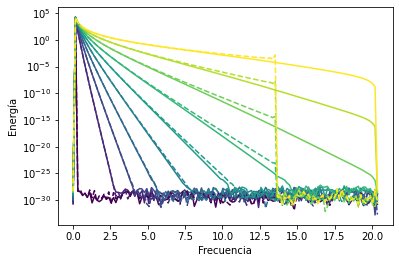

In [ ]:
fig, ax = plt.subplots()
set_prop_cycle(ax, 10)

for ls, y in zip(["-", "--"], (sol["y_diff"], sol["y_pseudoespectral"])):
    ax.semilogy(
        np.fft.rfftfreq(len(sol["x"]), sol["dx"]),
        np.abs(np.fft.rfft(y)).T**2,
        linestyle=ls,
    )
ax.set(xlabel="Frecuencia", ylabel="Energía")

## Extra

### Simulación interactiva

In [ ]:
@ipywidgets.interact(
    nu=ipywidgets.FloatLogSlider(min=-5, max=-1, step=0.1),
    tamaño_grilla=ipywidgets.FloatLogSlider(base=2, value=256, min=1, max=10, step=1),
    dt=ipywidgets.FloatLogSlider(value=1e-3, min=-3, max=-1, step=1),
    t_end=(0, 10, 0.1),
    n_puntos=(0, 20),
    threshold=(0, 1, 0.1)
)
def _(*, nu=0.1, tamaño_grilla, dt, t_end=1, n_puntos=10, threshold=1/3):
    sol = simular(
        nu=nu,
        tamaño_grilla=int(tamaño_grilla),
        dt=dt,
        t_end=t_end,
        n_points=n_puntos,
        threshold=threshold,
    )

    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].plot(sol["x"], sol["y_diff"].T)
    axes[1].plot(sol["x"], sol["y_pseudoespectral"].T)
    axes[0].set(title="Diferencias finitas")
    axes[1].set(title="Pseudoespectral")

interactive(children=(FloatLogSlider(value=0.1, description='nu', max=-1.0, min=-5.0), FloatLogSlider(value=25…